In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.0.0


In [2]:
# read training data
# report_id - ID to identify report
# report_params - number of parameters to execute report (when more params specified - report will be generated faster)
# day_part - when report is executed (morning, midday or afternoon) - there is less load in the morning and in the afternoon reports are generated slower
# exec_time - time spent to produce report

column_names = ['report_id','report_params','day_part','exec_time']
raw_dataframe = pd.read_csv('report_exec_times.csv')
dataframe = raw_dataframe.copy()

dataframe.head()

,report_id,report_params,day_part,exec_time
0,1,5,2,380
1,1,4,3,450
2,1,8,2,380
3,1,6,1,320
4,1,2,2,391


In [3]:
eps=0.001 # 0 => 0.1¢
dataframe['report_params'] = np.log(dataframe.pop('report_params')+eps)

dataframe.head()

,report_id,day_part,exec_time,report_params
0,1,2,380,1.609638
1,1,3,450,1.386544
2,1,2,380,2.079567
3,1,1,320,1.791926
4,1,2,391,0.693647


In [5]:
dataframe['report_id'] = dataframe['report_id'].apply(str)
dataframe['day_part'] = dataframe['day_part'].apply(str)

dataframe.head()

,report_id,day_part,exec_time,report_params
0,1,2,380,1.609638
1,1,3,450,1.386544
2,1,2,380,2.079567
3,1,1,320,1.791926
4,1,2,391,0.693647


In [6]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

960 train examples
240 validation examples
300 test examples


In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('exec_time')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [8]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('report_params'))

report_id = feature_column.categorical_column_with_vocabulary_list('report_id', ['1', '2', '3', '4', '5'])
report_id_one_hot = feature_column.indicator_column(report_id)
feature_columns.append(report_id_one_hot)

day_part = feature_column.categorical_column_with_vocabulary_list('day_part', ['1', '2', '3'])
day_part_one_hot = feature_column.indicator_column(day_part)
feature_columns.append(day_part_one_hot)

In [9]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [10]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [11]:
# Construct neural network with Keras API on top of TensorFlow. SGD optimizer and 
# mean squared error loss to check training quality

def build_model(feature_layer):
  model = keras.Sequential([
    feature_layer,
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model(feature_layer)

In [13]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=EPOCHS,
              callbacks=[early_stop])

W1030 12:40:54.245968 140680142403392 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4276: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W1030 12:40:54.247104 140680142403392 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4331: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Epoch 1/1000
30/30 [==============================] - 2s 54ms/step - loss: 279388.8375 - mae: 477.5024 - mse: 279388.8750 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/1000
30/30 [==============================] - 0s 4ms/step - loss: 280579.9820 - mae: 476.4844 - mse: 278405.3125 - val_loss: 308337.9062 - val_mae: 498.2344 - val_mse: 301624.0312
Epoch 3/1000
30/30 [==============================] - 0s 4ms/step - loss: 277339.8935 - mae: 475.1031 - mse: 277065.7188 - val_loss: 306709.4707 - val_mae: 496.6151 - val_mse: 300020.4062
Epoch 4/1000
30/30 [==============================] - 0s 4ms/step - loss: 273303.5560 - mae: 473.1922 - mse: 275245.0938 - val_loss: 304508.1738 - val_mae: 494.4197 - val_mse: 297850.5000
Epoch 5/1000
30/30 [==============================] - 0s 4ms/step - loss: 274696.8150 - mae: 470.6364 - mse: 272796.8125 - val_loss: 301596.3164 - val_mae: 491.5073 - val_mse: 294975.0312
Epoch 6/1000
30/30 [==============================] - 0s 4m

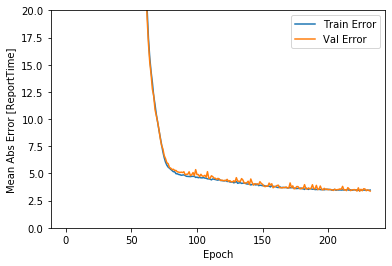

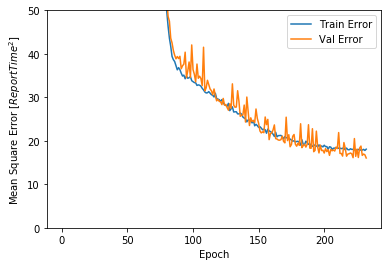

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ReportTime]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ReportTime^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


plot_history(history)

In [15]:
loss, mae, mse = model.evaluate(test_ds, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Report Execution Time".format(mae))

Testing set Mean Abs Error:  3.28 Report Execution Time


In [17]:
# Construct test data row with "unseen" feature values - report_params = 15 

headers = ['report_id', 'report_params', 'day_part']
dataframe_input = pd.DataFrame([[1, 15, 3]],
                                columns=headers, 
                                dtype=float,
                                index=['input'])

dataframe_input.head()

,report_id,report_params,day_part
input,1.0,15.0,3.0


In [18]:
eps=0.001 # 0 => 0.1¢
dataframe_input['report_params'] = np.log(dataframe_input.pop('report_params')+eps)

dataframe_input.head()

,report_id,day_part,report_params
input,1.0,3.0,2.708117


In [19]:
dataframe_input['report_id'] = dataframe_input['report_id'].apply(str)
dataframe_input['day_part'] = dataframe_input['day_part'].apply(str)

dataframe_input.head()

,report_id,day_part,report_params
input,1.0,3.0,2.708117


In [20]:
#input_ds = df_to_dataset(dataframe_input, shuffle=False)
input_ds = tf.data.Dataset.from_tensor_slices(dict(dataframe_input))
input_ds = input_ds.batch(1)

for feature_batch in input_ds.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'report_id'         : [b'1.0']
  'day_part'          : [b'3.0']
  'report_params'     : [2.70811687]


In [21]:
# Prediction result for report execution time. This is correct, model learns the rule correct - more report params, means execution time will be less

res = model.predict(input_ds)
print(res)

[[203.20584]]
